In [1]:
import os
import sys
sys.path.append('utils')
from dataset.spot import DailyDataset_nn, get_loader, TOTAL_STD, TOTAL_MEAN, SPOT
from tool import to_gpu, picp, mpiw, rpiw, cwc, MyLoss
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import trange, tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from pi_models import NN
import types

%matplotlib inline

In [2]:
model = to_gpu(NN(input_dim=336, hidden=[128], output_dim=24*2, bn=0, dropout=0))

In [3]:
dataset = DailyDataset_nn(N=2000, W=14)

Data build range: [window(2010-06-27 00:00:00) - 2010-07-11 00:00:00, 2015-12-31 00:00:00]


In [4]:
testX, testY = dataset.get_io(start_date='2016-01-01', end_date='2016-06-30')
loader = get_loader(dataset, batch_size=64, shuffle=True, num_workers=2)
with torch.no_grad():
    testX = to_gpu(testX)
    testY = to_gpu(testY) * TOTAL_STD

In [5]:
# Loss = MyLoss(lmd=0.003, alpha=0.01, s=50)
Loss = MyLoss(lmd=0.002, alpha=0.05, s=50)
criterion = nn.MSELoss()
metric = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
for epoch in range(90):
    print("------epoch%s------" % (epoch+1))
    model.eval()
    y = []
    for i in range(182):
        x = testX[i:i+14].reshape(14*24)
        y += [model(x)]
    test_out = torch.stack(y, 0) * TOTAL_STD
    test_out = test_out.data.cpu().numpy()
    lower_bound = test_out[:, :24].reshape(-1)
    upper_bound = test_out[:, 24:].reshape(-1)
    target = testY.data.cpu().numpy().reshape(-1)
    test_picp = picp(target,lower_bound,upper_bound)
    test_nmpiw = mpiw(target,lower_bound,upper_bound,norm=1)
    test_nrpiw = rpiw(target,lower_bound,upper_bound,norm=1)
    test_cwc_5 = cwc(target,lower_bound,upper_bound, alpha=0.05)
    test_cwc_1 = cwc(target,lower_bound,upper_bound, alpha=0.01)
    print("test_picp: ",test_picp, "test_nmpiw: ",test_nmpiw, "test_nrpiw: ",test_nrpiw, \
          "test_cwc_5: ",test_cwc_5, "test_cwc_1: ",test_cwc_1)
    
    model.train()
    
    train_out = to_gpu(torch.Tensor([]))
    train_y = to_gpu(torch.Tensor([]))
    
    for _, (x, y, item) in enumerate(loader):
        B, W, D = x.shape
        x = to_gpu(x.reshape(B, W*D))
        y = to_gpu(y)

        optimizer.zero_grad()
        out = model(x)
        loss = Loss(out, y)
        loss.backward(retain_graph=True)
        optimizer.step()
#         print(loss)
        train_out = torch.cat((train_out, out), 0)
        train_y = torch.cat((train_y, y), 0)
        

------epoch1------
test_picp:  0.04075091575091575 test_nmpiw:  0.004991244 test_nrpiw:  0.0669292286391166 test_cwc_5:  2.7688651460815792e+17 test_cwc_1:  2.0459299894770598e+18
------epoch2------
test_picp:  0.9123168498168498 test_nmpiw:  0.39641976 test_nrpiw:  0.41616193624248526 test_cwc_5:  3.0051820497901804 test_cwc_1:  19.67271064525707
------epoch3------
test_picp:  0.9127747252747253 test_nmpiw:  0.34940016 test_nrpiw:  0.3693777410464227 test_cwc_5:  2.59669302750369 test_cwc_1:  16.954773211481275
------epoch4------
test_picp:  0.8978937728937729 test_nmpiw:  0.29394817 test_nrpiw:  0.3142480933070578 test_cwc_5:  4.27266573880679 test_cwc_1:  29.692915465206074
------epoch5------
test_picp:  0.9127747252747253 test_nmpiw:  0.28116032 test_nrpiw:  0.30277360935142306 test_cwc_5:  2.0895441187395645 test_cwc_1:  13.643409626540256
------epoch6------
test_picp:  0.9162087912087912 test_nmpiw:  0.2661521 test_nrpiw:  0.2864890443826779 test_cwc_5:  1.70792447297616 test_cwc

------epoch49------
test_picp:  0.9608516483516484 test_nmpiw:  0.15284066 test_nrpiw:  0.1559093481786723 test_cwc_5:  0.15284065902233124 test_cwc_1:  0.8092689882925611
------epoch50------
test_picp:  0.9578754578754579 test_nmpiw:  0.1499303 test_nrpiw:  0.15281025704731113 test_cwc_5:  0.14993029832839966 test_cwc_1:  0.8971786643578064
------epoch51------
test_picp:  0.9581043956043956 test_nmpiw:  0.14752366 test_nrpiw:  0.15037144488533752 test_cwc_5:  0.1475236564874649 test_cwc_1:  0.8744090090006382
------epoch52------
test_picp:  0.9722985347985348 test_nmpiw:  0.16211806 test_nrpiw:  0.1647249386877922 test_cwc_5:  0.162118062376976 test_cwc_1:  0.5549563754036981
------epoch53------
test_picp:  0.9581043956043956 test_nmpiw:  0.14658044 test_nrpiw:  0.1500194149423381 test_cwc_5:  0.14658044278621674 test_cwc_1:  0.8688183493232574
------epoch54------
test_picp:  0.961996336996337 test_nmpiw:  0.14593111 test_nrpiw:  0.1492605737506551 test_cwc_5:  0.14593110978603363 tes

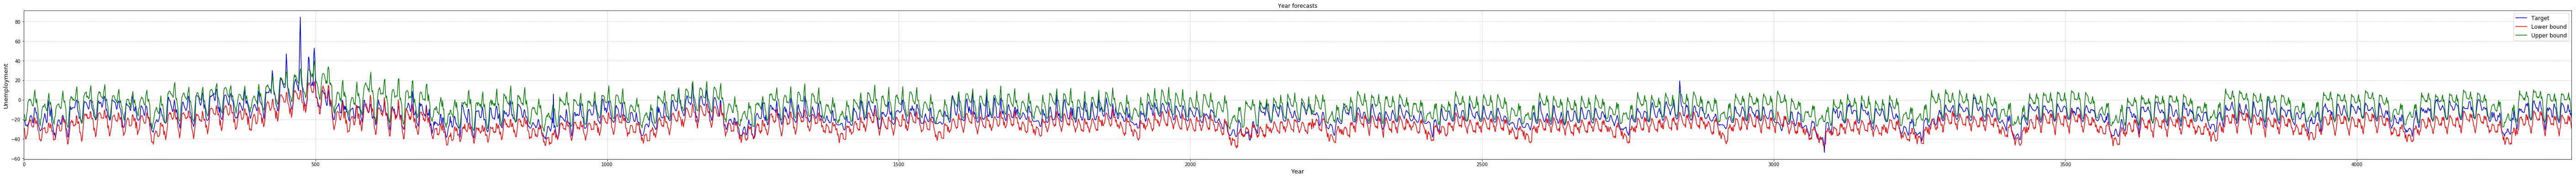

In [7]:
x=np.linspace(1, 182*24, 182*24)
plt.figure(figsize=(100,6))
plt.plot(x, target, color='blue', label='Target')
plt.plot(x, lower_bound, color='red', label='Lower bound')
plt.plot(x, upper_bound, color='green', label='Upper bound')

plt.xlim(0,182*24)
plt.legend(fontsize='large') # 显示图例

plt.title('Year forecasts')
plt.xlabel('Year',fontsize=13)
plt.ylabel('Unemployment',fontsize=13)

plt.grid(linestyle=':', linewidth=1)
plt.show()

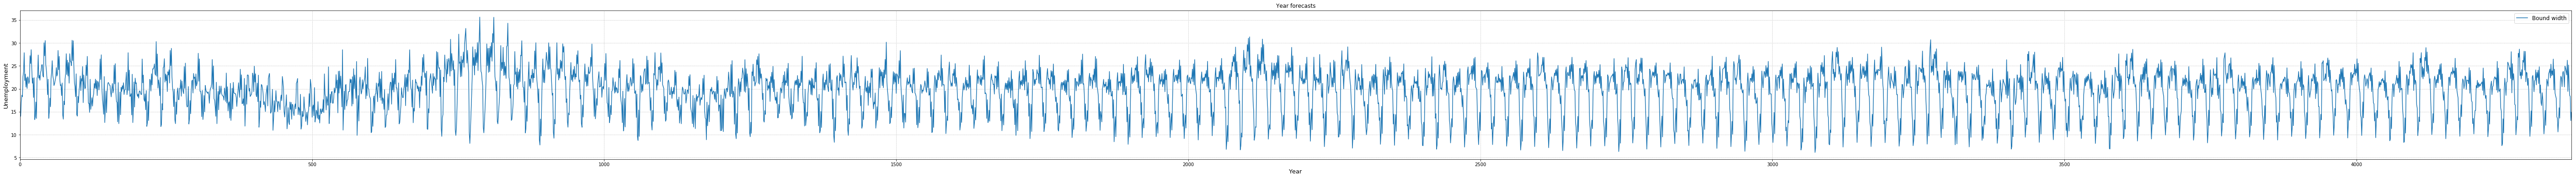

In [8]:
x=np.linspace(1, 182*24, 182*24)
plt.figure(figsize=(100,6))
plt.plot(x, upper_bound-lower_bound, label='Bound width')

plt.xlim(0,182*24)
plt.legend(fontsize='large') # 显示图例

plt.title('Year forecasts')
plt.xlabel('Year',fontsize=13)
plt.ylabel('Unemployment',fontsize=13)

plt.grid(linestyle=':', linewidth=1)
plt.show()

In [9]:
# save bounds
bounds = np.append(lower_bound, upper_bound)
np.save('./bounds/nn-lube_95.npy', bounds)